# Credit risk analysis using QAE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import IntegerComparator
from qiskit_algorithms import EstimationProblem, IterativeAmplitudeEstimation
from qiskit_aer.primitives import Sampler

In [3]:
z_qubits = 2
z_max = 2
truncation_values = np.linspace(-z_max, z_max, 2**z_qubits)
base_default_probablities = [0.15, 0.25]
sensitivity_wrt_z = [0.1, 0.05]
loss_given_default = [1, 2]
K = len(base_default_probablities)
alpha = 0.05

# Implementing the Uncertainity model

from qiskit_finance.circuit.library import  GaussianConditionalIndependenceModel as GCI
gci = GCI(z_qubits, z_max, base_default_probablities, sensitivity_wrt_z)
print(gci.draw())

gci_final = gci.measure_all(inplace=False)
print(gci_final.decompose())
sampler = Sampler()
job = sampler.run(gci_final)
binary_probablilities = job.result().quasi_dists[0].binary_probabilities()
p_z = np.zeros(2**z_qubits)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = gci.num_qubits
for i, prob in binary_probablilities.items():
  data_qubits = i[-z_qubits:]
  decimal_value = int(data_qubits, 2)
  p_z[decimal_value] += prob

  loss = 0
  for k in range(K):
    if i[K - k - 1] == "1":
      p_default[k] += prob
      loss += loss_given_default[k]
  values += [loss]
  probabilities += [prob]

values = np.array(values)
probabilities = np.array(probabilities) 

expected_loss = np.dot(values, probabilities)
print(f"Values: {values}")
print(f"Probablities: {probabilities}")
print("Expected loss:", str(expected_loss))
print("P Defualt:", str(p_default))
losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i,v in enumerate(losses):
  pdf[i] += sum(probabilities[values == v])

print(f"PDF: {pdf}")

cdf = np.cumsum(pdf)
print(f"CDF: {cdf}")
i_var = np.argmax(cdf >= 1 - alpha)
print(f"IVAR: {i_var}")
exact_var = losses[i_var]
print(f"Exact Var: {exact_var}")
exact_cvar = np.dot(pdf[(i_var + 1):], losses[(i_var+1):]) / sum(pdf[(i_var+1):])
print(f"Exact CVar: {exact_cvar}")


print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)



     ┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │  P(X) │
q_2: ┤2      ├
     │       │
q_3: ┤3      ├
     └───────┘
        ┌───────┐┌─────────┐┌─────────┐ ░ ┌─┐         
   q_0: ┤0      ├┤0        ├┤0        ├─░─┤M├─────────
        │  P(X) ││         ││         │ ░ └╥┘┌─┐      
   q_1: ┤1      ├┤1 LinRot ├┤1        ├─░──╫─┤M├──────
        └───────┘│         ││  LinRot │ ░  ║ └╥┘┌─┐   
   q_2: ─────────┤2        ├┤         ├─░──╫──╫─┤M├───
                 └─────────┘│         │ ░  ║  ║ └╥┘┌─┐
   q_3: ────────────────────┤2        ├─░──╫──╫──╫─┤M├
                            └─────────┘ ░  ║  ║  ║ └╥┘
meas: 4/═══════════════════════════════════╩══╩══╩══╩═
                                           0  1  2  3 
Values: [1 3 2 1 3 2 0 0 2 0 0 3 1 1 2]
Probablities: [0.00097656 0.00488281 0.00683594 0.05566406 0.02539062 0.09863281
 0.23632812 0.06054688 0.015625   0.0390625  0.33105469 0.01171875
 0.00878906 0.0234375  0.08105469]
Expected loss: 0.619140625
P Defualt:

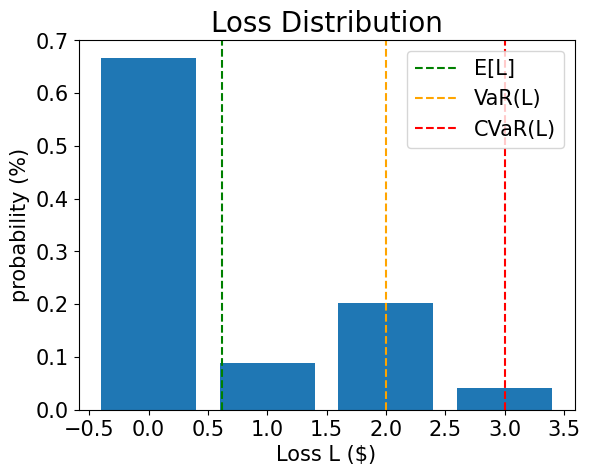

In [4]:
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

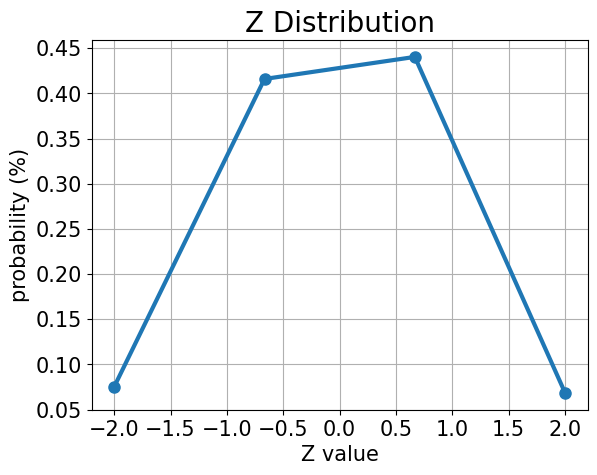

In [5]:
plt.plot(truncation_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

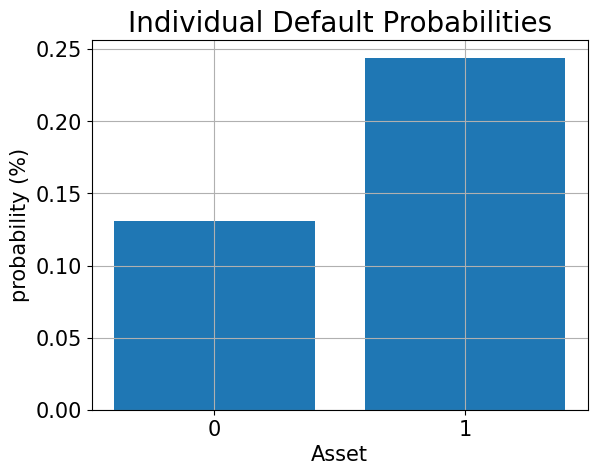

In [6]:
# plot results for default probabilities
plt.bar(range(K), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

In [7]:
from qiskit.circuit.library import WeightedAdder, LinearAmplitudeFunction


# Evaluate expected loss
agg = WeightedAdder(z_qubits + K, [0]*z_qubits + loss_given_default)
print(agg.decompose())
breakpoints, slopes, offsets, fmin, fmax, capprox = [0], [1], [0],0, sum(loss_given_default), 0.25
objective = LinearAmplitudeFunction(
  agg.num_sum_qubits,
  slope=slopes,
  offset=offsets,
  domain=(0, 2**agg.num_sum_qubits-1),
  image=(fmin, fmax),
  rescaling_factor=capprox,
  breakpoints=breakpoints
)
# State preperation circuit
qr_state = QuantumRegister(gci.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")

state_preperation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")
state_preperation.append(gci.to_gate(), qr_state)
state_preperation.append(agg.to_gate(), qr_state[:] + qr_sum[:]+ qr_carry[:])
state_preperation.append(objective.to_gate(), qr_sum[:] +  qr_obj[:])
state_preperation.append(agg.to_gate().inverse(), qr_state[:]+ qr_sum[:]+qr_carry[:])
print(state_preperation.draw())
print(state_preperation.decompose().draw())


# Testing: Sanity
final_state_preperation = state_preperation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(final_state_preperation)
binary_probablilities = job.result().quasi_dists[0].binary_probabilities()
value = 0
for i, prob in binary_probablilities.items():
  if prob > 1e-6 and i[-(len(qr_state) + 1):][0] == "1":
    value += prob

print(f"Exact Expected Loss: {expected_loss}")
print(f"Exact Operator Value: {value}")
print(f"Mapped Operator Value: {objective.post_processing(value)}")



                                                 
state_0: ────────────────────────────────────────
                                                 
state_1: ────────────────────────────────────────
                                                 
state_2: ──■────■────■──────────────■────────────
           │    │    │              │            
state_3: ──┼────┼────┼─────────■────┼────■───────
           │  ┌─┴─┐  │  ┌───┐  │    │    │  ┌───┐
  sum_0: ──■──┤ X ├──┼──┤ X ├──┼────■────┼──┤ X ├
           │  └───┘┌─┴─┐└───┘┌─┴─┐  │  ┌─┴─┐└───┘
  sum_1: ──┼───────┤ X ├─────┤ X ├──┼──┤ X ├─────
         ┌─┴─┐     └─┬─┘     └───┘┌─┴─┐└─┬─┘     
  carry: ┤ X ├───────■────────────┤ X ├──■───────
         └───┘                    └───┘          
           ┌───────┐┌────────┐      ┌───────────┐
  state_0: ┤0      ├┤0       ├──────┤0          ├
           │       ││        │      │           │
  state_1: ┤1      ├┤1       ├──────┤1          ├
           │  P(X) ││        │      │           │


In [7]:
# QAE to estimate expected loss
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
  state_preparation=state_preperation,
  objective_qubits=[len(qr_state)],
  post_processing=objective.post_processing
)
estimator = IterativeAmplitudeEstimation(epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75}))
try:
  result = estimator.estimate(problem)
except Exception as e:
  print(e)
  raise e

confidence_interval = np.array(result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(confidence_interval))

: 

In [8]:
x_eval = 2
comparator = IntegerComparator(agg.num_sum_qubits, x_eval+1, geq=False)
comparator.draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │  cmp │
compare: ┤2     ├
         │      │
     a0: ┤3     ├
         └──────┘

In [9]:
def get_cdf_circuit(x_eval):
  qr_state = QuantumRegister(gci.num_qubits, "state")
  qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
  qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
  qr_obj = QuantumRegister(1, "objective")
  # qr_compare = QuantumRegister(1, "Compare")

  cdf = QuantumCircuit(qr_state,qr_sum,qr_carry,qr_obj, name="CDF")
  cdf.append(gci.to_gate(), qr_state[:])
  cdf.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])
  comparator = IntegerComparator(agg.num_sum_qubits, x_eval+1, geq=False)
  cdf.append(comparator.to_gate(), qr_sum[:] + qr_obj[:] + qr_carry[:])
  cdf.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:]+ qr_carry[:])
  return cdf

state_preperation = get_cdf_circuit(x_eval)
print(state_preperation.draw())
state_preperation_final = state_preperation.measure_all(inplace=False)
sampler = Sampler()
result = sampler.run(state_preperation_final)
binary_probablilities = result.result().quasi_dists[0].binary_probabilities()
var_prob = 0
for i, prob in binary_probablilities.items():
  if prob > 1e-6 and i[(-len(qr_state)+1):][0] == "1":
    var_prob+= prob


print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

           ┌───────┐┌────────┐        ┌───────────┐
  state_0: ┤0      ├┤0       ├────────┤0          ├
           │       ││        │        │           │
  state_1: ┤1      ├┤1       ├────────┤1          ├
           │  P(X) ││        │        │           │
  state_2: ┤2      ├┤2       ├────────┤2          ├
           │       ││        │        │           │
  state_3: ┤3      ├┤3 adder ├────────┤3 adder_dg ├
           └───────┘│        │┌──────┐│           │
    sum_0: ─────────┤4       ├┤0     ├┤4          ├
                    │        ││      ││           │
    sum_1: ─────────┤5       ├┤1     ├┤5          ├
                    │        ││  cmp ││           │
    carry: ─────────┤6       ├┤3     ├┤6          ├
                    └────────┘│      │└───────────┘
objective: ───────────────────┤2     ├─────────────
                              └──────┘             
Operator CDF(2) = 0.1348
Exact    CDF(2) = 0.9580


In [16]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(state_preparation=state_preperation, objective_qubits=[len(qr_state)])
ae_cdf = IterativeAmplitudeEstimation(epsilon, alpha, sampler=sampler)
result_cdf = ae_cdf.estimate(problem)

conf_int = np.array(result_cdf.confidence_interval_processed)
print("Exact value:    \t%.4f" % cdf[x_eval])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

: 

In [10]:
def run_ae_for_cdf(x_eval, epsilon = 0.01, alpha = 0.05):
  state_preperation = get_cdf_circuit(x_eval)
  problem = EstimationProblem(state_preparation=state_preperation, objective_qubits=[len(qr_state)])
  ae_var = IterativeAmplitudeEstimation(epsilon, alpha, sampler=Sampler())
  result_var = ae_var.estimate(problem)
  return result_var.estimation

def bisection_search(objective, target_value, low_level, high_level, low_value=None, high_value=None):
  # check whether low and high values are given and evaluated them otherwise
    print("--------------------------------------------------------------------")
    print("start bisection search for target value %.3f" % target_value)
    print("--------------------------------------------------------------------")
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "success"}

    # check if high_value is above target
    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    # perform bisection search until
    print("low_level    low_value    level    value    high_level    high_value")
    print("--------------------------------------------------------------------")
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print(
            "%2d           %.3f        %2d       %.3f    %2d            %.3f"
            % (low_level, low_value, level, value, high_level, high_value)
        )

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print("--------------------------------------------------------------------")
    print("finished bisection search")
    print("--------------------------------------------------------------------")
    return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}


objective = lambda x: run_ae_for_cdf(x)
bisection_result = bisection_search(objective, 1-alpha, min(losses), max(losses), low_value=0, high_value=1)
var = bisection_result["level"]


: 

In [ ]:
print("Estimated Value at Risk: %2d" % var)
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Probability:    %.3f" % bisection_result["value"])
print("Exact Probability:        %.3f" % cdf[exact_var])

In [ ]:
# Conditional value at risk

break_points = [0, var]
slopes = [0,1]
offsets = [0,0]
fmin =0
fmax = 3 - var
capprox = 0.25

cvar_objective = LinearAmplitudeFunction(
  agg.num_sum_qubits,
  slopes,
  offsets,
  domain=(0, 2**agg.num_sum_qubits - 1),
  image=(fmin, fmax),
  rescaling_factor=capprox,
  breakpoints = breakpoints
)
cvar_objective.draw()

# define the registers for convenience and readability
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), "work")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_work, name="A")

# load the random variable
state_preparation.append(u, qr_state)

# aggregate
state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:])

# uncompute aggregation
state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])


state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

# evaluate the result
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1)] == "1":
        value += prob

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - bisection_result["value"]
v = value / d if d != 0 else 0
normalized_value = v + var
print("Estimated CVaR: %.4f" % normalized_value)
print("Exact CVaR:     %.4f" % exact_cvar)

In [ ]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=cvar_objective.post_processing,
)
# construct amplitude estimation
ae_cvar = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)
result_cvar = ae_cvar.estimate(problem)

# print results
d = 1.0 - bisection_result["value"]
v = result_cvar.estimation_processed / d if d != 0 else 0
print("Exact CVaR:    \t%.4f" % exact_cvar)
print("Estimated CVaR:\t%.4f" % (v + var))